In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import os
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [57]:
data = pd.read_csv('all_stocks_5yr.csv', delimiter=',', on_bad_lines='skip')
print(data.shape)
print(data.sample(7))

(619040, 7)
              date      open    high       low   close    volume  Name
553855  2015-10-19   38.8200   38.96   38.3400   38.51   2754569   TXT
346815  2015-10-23  218.0000  219.42  217.2300  219.32   1280865   LMT
407556  2013-03-26   26.2857   27.52   26.2285   27.23  46804100  NFLX
166081  2016-12-01   78.1300   78.32   76.9100   77.02   3936665   DHR
459668  2015-12-21   48.5300   49.31   48.2200   48.64   3282862   PNR
24868   2016-11-10   61.5200   63.47   61.5000   63.21  12562020   AIG
371799  2015-01-14   71.7900   72.46   71.4100   71.77   8702313   MDT


In [58]:
data['date'] = pd.to_datetime(data['date'])
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB


,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


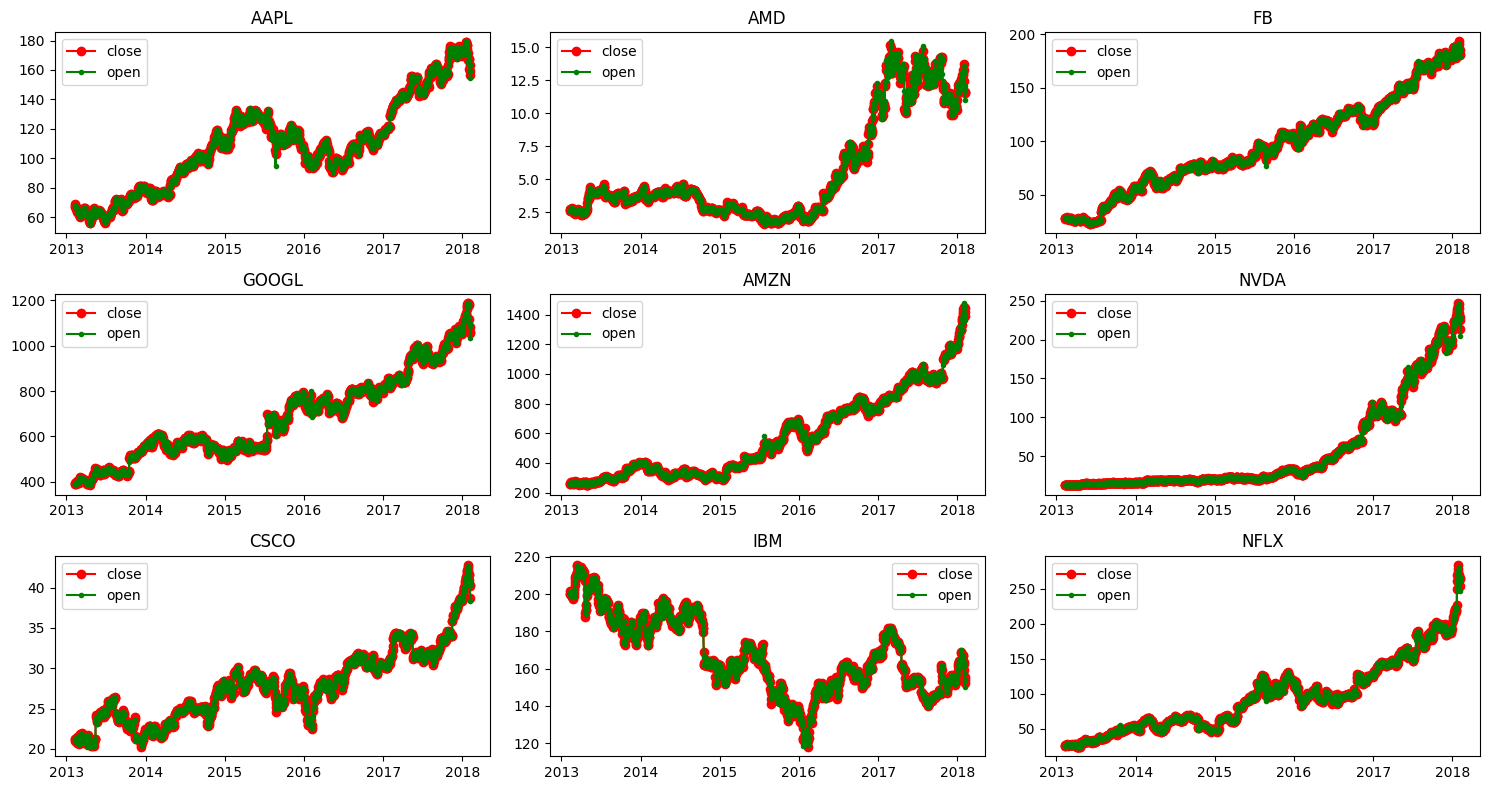

In [73]:
companies = ['AAPL', 'AMD', 'FB', 'GOOGL', 'AMZN', 'NVDA', 'CSCO', 'IBM', 'NFLX']

plt.figure(figsize=(15,8))
for index, company in enumerate(companies,1):
    plt.subplot(3,3, index)
    c = data[data['Name'] == company]
    plt.plot(c['date'], c['close'], c='r', label='close', marker='o')
    plt.plot(c['date'], c['open'], c='g', label='open', marker=".")
    plt.title(company)
    plt.legend()
    plt.tight_layout()
    

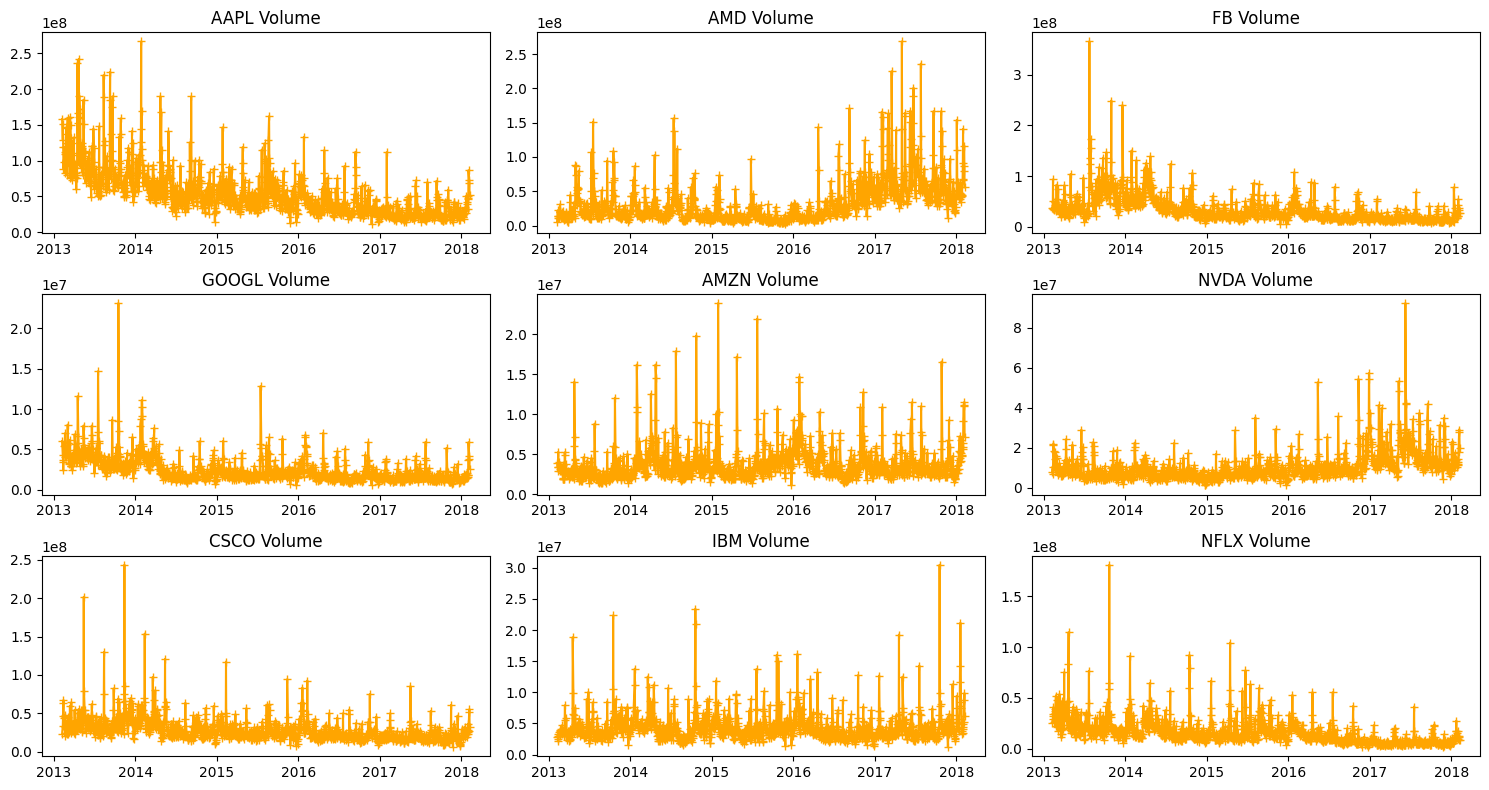

In [75]:
plt.figure(figsize=(15,8))
for index, company in enumerate(companies, 1):
    plt.subplot(3,3,index)
    c = data[data['Name'] == company]
    plt.plot(c['date'], c['volume'], c='orange',marker="+")
    plt.title(f"{company} Volume")
    plt.tight_layout()

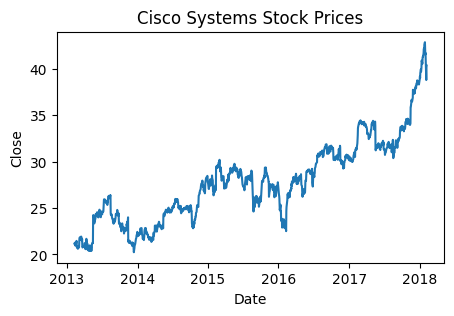

In [61]:
plt.figure(figsize=(5, 3))
cisco = data[data['Name'] == 'CSCO']
prediction_range = cisco.loc[(cisco['date'] > datetime (2013, 1, 1)) & (cisco['date'] < datetime(2018, 1, 1))]
plt.plot(cisco['date'], cisco['close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Cisco Systems Stock Prices")
plt.show()

In [62]:
close_data = cisco.filter(['close'])
dataset = close_data.values
training = int(np.ceil(len(dataset)* .95))
print("Training data length:",training)

Training data length: 1197


In [63]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [64]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
                            return_sequences=True,
                            input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0377
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0065
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0063
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0059
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0046
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0046
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0047
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0038
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0044
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0035


In [66]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

mse = np.mean(((predictions - y_test) ** 2))
rmse = np.sqrt(mse)

print("MSE", mse)
print("RMSE", np.sqrt(mse))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
MSE 0.9048709421462271
RMSE 0.9512470458015768


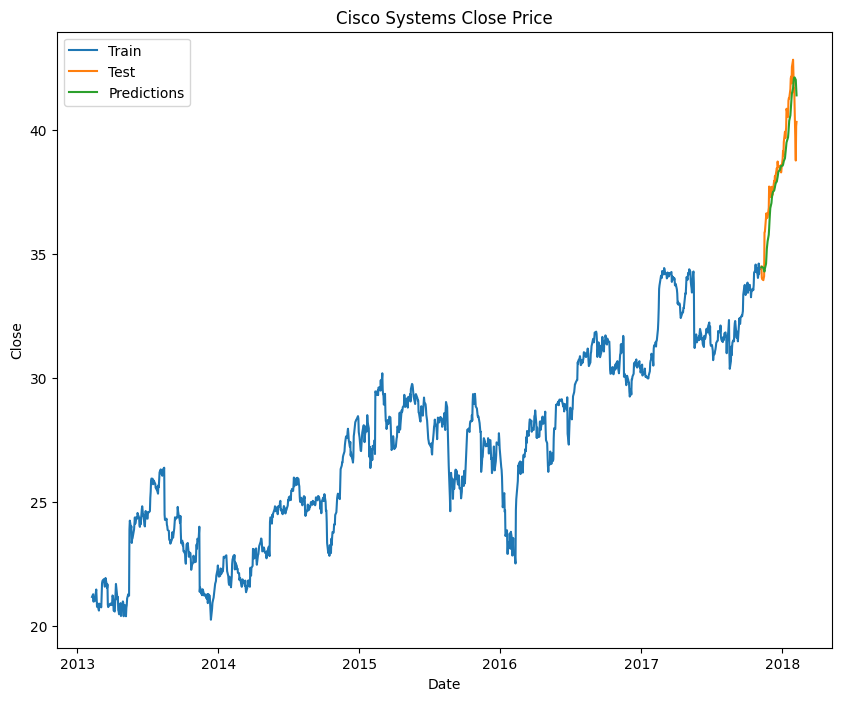

In [67]:
train = cisco[:training]
test = cisco[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10,8))
plt.plot(train['date'], train['close'])
plt.plot(test['date'], test[['close','Predictions']])
plt.title('Cisco Systems Close Price')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend(['Train', 'Test', 'Predictions'])

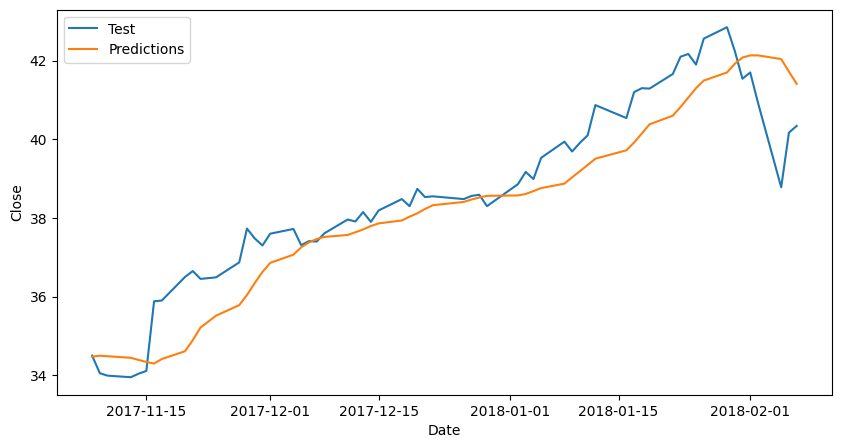

In [68]:
plt.figure(figsize=(10,5))
plt.plot(test['date'], test[['close','Predictions']])
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend([ 'Test', 'Predictions'])